**Professor J. Morlier**
Example from
Ebden, M. (2008). Gaussian processes for regression: A quick introduction. The website of robotics research group in department on engineering science, University of Oxford, 91, 424-436.

**EXERCICE 1:** Given some noisy observations of a dependent variable at certain values of the independent variable , what is our best estimate of the dependent variable at a new value x*

Text(0, 0.5, 'y')

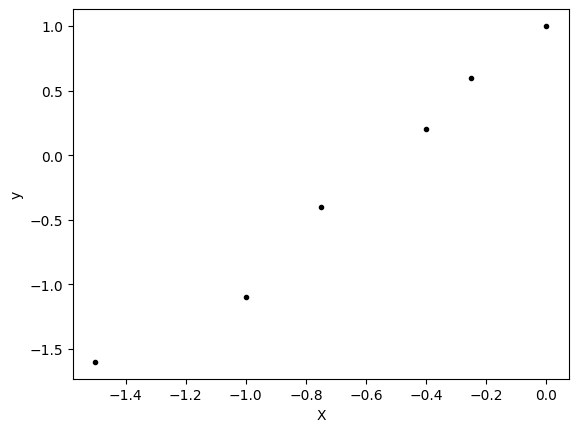

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs
X = np.array([-1.5, -1, -0.75, -0.4, -0.25, 0]).reshape(-1, 1)
n = X.shape[0]

# Outputs
y = np.array([-1.6, -1.10, -.4, .2, 0.6, 1]).reshape(-1, 1)

# y = 0.55 * np.array([-3, -2, -0.6, 0.4, 1, 1.6]).reshape(-1, 1)

# Plotting data
plt.figure()
plt.plot(X, y, 'k.')
plt.xlabel('X')
plt.ylabel('y')



What if we want to estimate the model at a new point  x* defined as 18 points in [-1.5,0]. Please check also x*= 0.2 (extrapolation) !!
The regression problem is defined as follows:
Let $\mathbf{x}_i \in {R}^{6}$ be an input vector and $\mathbf{y}_i \in {R}^{6}$ be its corresponding target. The set of $M$ inputs are arranged into a matrix $\mathbf{X} = [\mathbf{x}_1, \dots, \mathbf{x}_M]^\top$ and their corresponding targets are stored in a matrix $\mathbf{Y} = [\mathbf{y}_1 - \mathbf{\bar{y}}, \dots, \mathbf{y}_M-\mathbf{\bar{y}}]^\top$, with $\mathbf{\bar{y}}$  being the mean target value in $\mathbf{Y}$.

In [2]:

# Interpolation and extrapolation points
# go up to xstar = 0.2 # Extrapolation
# N=1
xstar = np.arange(-1.5, 0.21, 0.1).reshape(-1, 1) # 18 points in [-1.5,0] interpolation
N = xstar.shape[0]

# Computing covariance in matrix form
covXXInd1, covXXInd2 = np.meshgrid(X, X)
covXXsInd1, covXXsInd2 = np.meshgrid(X, xstar)
covXsXsInd1, covXsXsInd2 = np.meshgrid(xstar, xstar)




hey hey add something missing, we may need parameters to fit "a model" of our covariance matrix. Let's try with a Standard Exponential (SE) Kernel $k(x,x') =\sigma_f^2\exp\left(-\frac{(x-x')^2}{l^ 2}\right)$


In [4]:
# Judicious Hyperparameters
l = 1
sig_f = 3**(1/4)

# Computing covariance matrices
covXX = (sig_f**2) * np.exp(-(covXXInd1 - covXXInd2) ** 2 / l ** 2)
covXsXs = (sig_f**2) * np.exp(-(covXsXsInd1 - covXsXsInd2) ** 2 / l ** 2)
covXXs = (sig_f**2) * np.exp(-(covXXsInd1 - covXXsInd2) ** 2 / l ** 2)


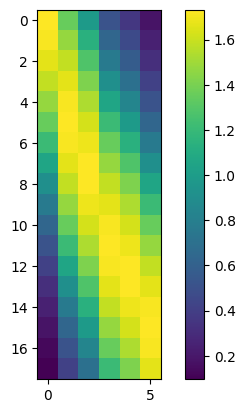

In [5]:
# Gram Matrix
plt.imshow(covXXs)
plt.colorbar()
plt.show()

I wish to train a GPR model $\mathcal{G} = \lbrace \mathbf{X}, \mathbf{Y}, \theta \rbrace$ using the squared exponential function ( $\theta$ must be chosen):
$k(\mathbf{x}_i, \mathbf{x}_j) = \sigma_f^2 \text{exp} \left( - \frac{1}{l^2}(\mathbf{x}_i - \mathbf{x}_j)^2\right) + \sigma_n^2\delta_{ij}$
, where $\delta_{ij}$ equals 1 if $i = j$ and 0 otherwise.

In [6]:
# Adding noise to covariance matrix, let's try less?
sig_n =  0.2
covXX_noisy = covXX + sig_n ** 2 * np.eye(n)




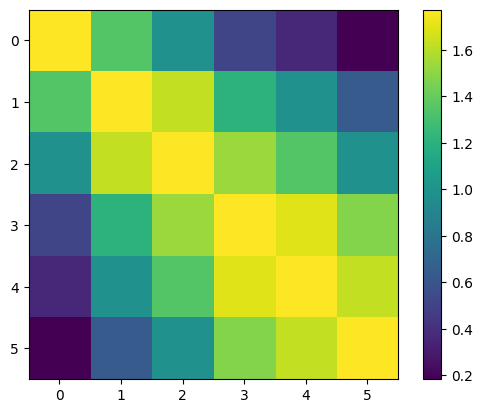

In [7]:
plt.imshow(covXX_noisy)
plt.colorbar()
plt.show()

In [8]:
# Computing posterior mean and covariance

#posterior_mean = covXXs @ np.linalg.inv(covXX_noisy) @ y
#posterior_cov = covXsXs - covXXs @ np.linalg.inv(covXX_noisy) @ covXXs.T
posterior_mean = covXXs.dot(np.linalg.inv(covXX_noisy)).dot(y)
posterior_cov = covXsXs - covXXs.dot(np.linalg.inv(covXX_noisy)).dot(covXXs.T)


Text(0, 0.5, 'y')

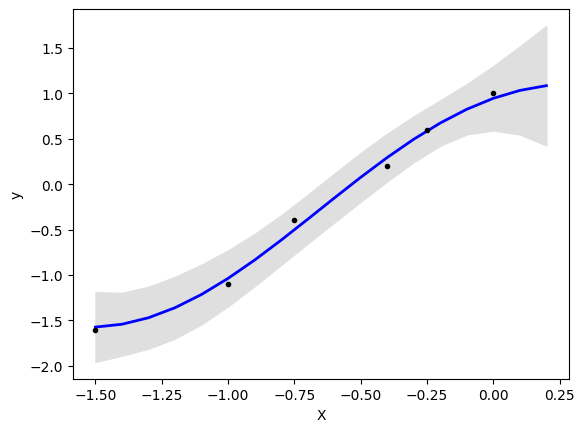

In [9]:
# Plotting mean and variance of the posterior
upper_bound = posterior_mean.flatten() + 2 * np.sqrt(np.diag(posterior_cov))
lower_bound = posterior_mean.flatten() - 2 * np.sqrt(np.diag(posterior_cov))
plt.figure()
plt.fill_between(xstar.flatten(), upper_bound, lower_bound, color=[7/8, 7/8, 7/8])
plt.plot(xstar, posterior_mean, 'b-', linewidth=2)
plt.plot(X, y, 'k.')
plt.xlabel('X')
plt.ylabel('y')

Text(0, 0.5, 'y')

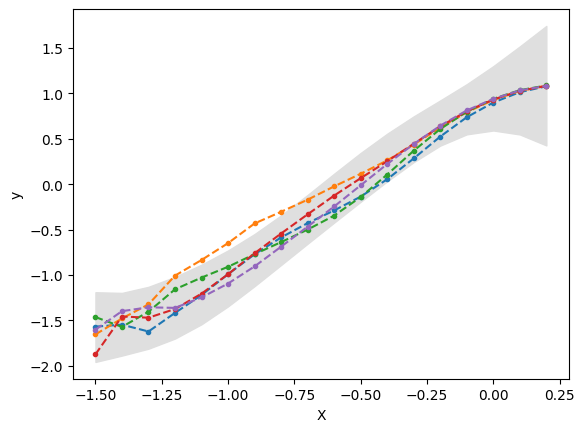

In [10]:
# Generating random function samples from posterior
jitter = 10 ** (-6)
L = np.linalg.cholesky(posterior_cov + jitter * np.eye(N))
random_functions = posterior_mean + L.T @ np.random.randn(N, 5)
plt.figure()
plt.fill_between(xstar.flatten(), upper_bound, lower_bound, color=[7/8, 7/8, 7/8])
plt.plot(xstar, random_functions,'.--')
plt.xlabel('X')
plt.ylabel('y')

but is there a way to find the \theta_{optimal} ? oh $\theta = [l, \sigma_f, \sigma_n]$

The hyperparameters are $\theta = [l, \sigma_f, \sigma_n]$  with $\sigma_n$ being the assumed noise level in the training data and $l$ is the length-scale  (of oscillations) and $\sigma_f$ the amplitude.
To train the model, I need to minimise the negative log marginal likelihood with respect to the hyperparameters:
$-\text{log}\, p(\mathbf{Y} \mid \mathbf{X}, \theta) = \frac{1}{2} \text{tr}(\mathbf{Y}^\top\mathbf{K}^{-1}\mathbf{Y}) + \frac{1}{2}\text{log}\mid\mathbf{K}\mid + \,c,$
where c is a constant and the matrix $\mathbf{K}$ is a function of the hyperparameters (see equation k(xi,xj) = ...).

For this purpose. Let's move to **EXERCICE 2** and use scikit learn and SMT